In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage
import imgaug
import imgaug.augmenters as iaa

from tqdm import tqdm


# Root directory of the project
ROOT_DIR = os.path.abspath("./")

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from moles import MolesConfig
from moles import MolesDataset
from moles import BalancedDataset
from moles import BalancedDatasetFast
from moles import ISIC17Dataset
from moles import ISIC17AugDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3

In [2]:
config = MolesConfig()

In [3]:
dataset_train = ISIC17Dataset()
dataset_train.load_moles("data/train/")
dataset_train.prepare()
ds = dataset_train

dataset_val = ISIC17Dataset()
dataset_val.load_moles("data/val/")
dataset_val.prepare()

In [ ]:
len(ds.image_ids)

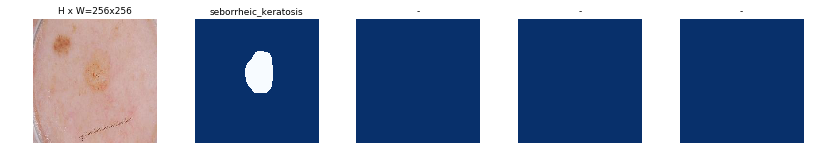

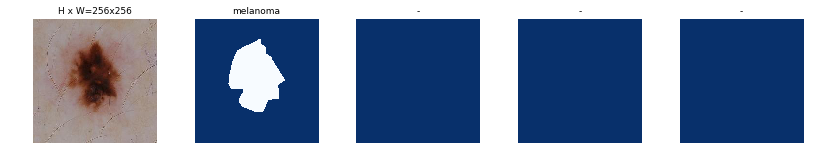

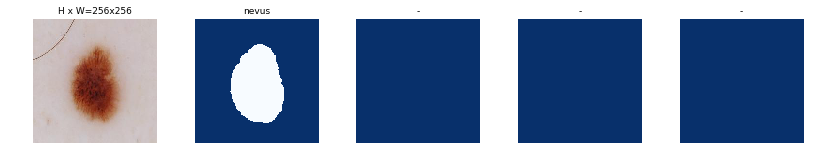

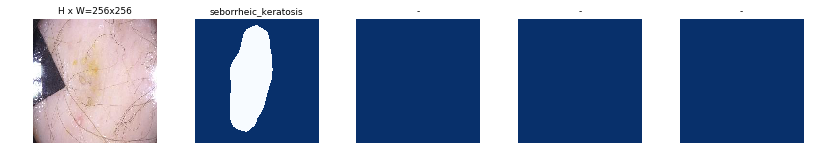

In [4]:
ds = dataset_train

# Load and display random samples
image_ids = np.random.choice(ds.image_ids, 4)
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

In [4]:
augmentation = iaa.SomeOf((5,8), [
    iaa.Fliplr(1.0),
    iaa.OneOf([
        iaa.GaussianBlur((1, 6.0)),
        iaa.AverageBlur(k=(1, 3)),
        iaa.MedianBlur(k=(3, 5)),
    ]),
    iaa.Flipud(1.0),
    iaa.Rot90((1,3)),
    iaa.CropAndPad(percent=(-0.25, 0.25)),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.2),
    iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5),
               iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),]),
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
])

In [5]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [6]:
COCO_MODEL_PATH = ROOT_DIR + "/mask_rcnn_coco.h5"
LATEST_MODEL_PATH = ROOT_DIR + "/logs/moles20200729T1201/mask_rcnn_moles_0120.h5"

LATEST = True

if LATEST:
    model.load_weights(LATEST_MODEL_PATH, by_name=True)
else:
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])


model.keras_model.metrics_tensors = []

Re-starting from epoch 120


In [9]:
# Train top layers
model.train(ds, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='heads',
            augmentation=augmentation
            )


Starting at epoch 20. LR=0.001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 21/40
400/400 [==============================] - 655s 2s/step - loss: 2.3832 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 1.7985 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2314 - val_loss: 2.0483 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.1822 - val_mrcnn_class_loss: 1.5329 - val_mrcnn_bbox_loss: 0.1264 - val_mrcnn_mask_loss: 0.2041
Epoch 22/40
400/400 [==============================] - 557s 1s/step - loss: 2.3556 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 1.7639 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2338 - val_loss: 1.7778 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.1635 - val_mrcnn_class_loss: 1.2882 - val_mrcnn_bbox_loss: 0.1169 - val_mrcnn_mask_loss: 0.2063
Epoch 23/40
400/400 [==============================] - 633s 2s/step - loss: 2.3239 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 1.7440 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2313 - val_loss: 2.1866 - val_rpn_clas

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 633s 2s/step - loss: 1.9657 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 1.4002 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.2305 - val_loss: 1.6689 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.1392 - val_mrcnn_class_loss: 1.2052 - val_mrcnn_bbox_loss: 0.1248 - val_mrcnn_mask_loss: 0.1975
Epoch 40/40
400/400 [==============================] - 627s 2s/step - loss: 1.8791 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 1.3275 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2275 - val_loss: 1.4773 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.1431 - val_mrcnn_class_loss: 0.9988 - val_mrcnn_bbox_loss: 0.1283 - val_mrcnn_mask_loss: 0.2048


In [7]:
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/3,
            epochs=120,
            augmentation=augmentation,
            layers="4+")


Starting at epoch 80. LR=0.0003333333333333333

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_b

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 81/120
400/400 [==============================] - 668s 2s/step - loss: 0.6604 - rpn_class_loss: 8.4690e-04 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.2069 - val_loss: 0.8070 - val_rpn_class_loss: 8.8035e-04 - val_rpn_bbox_loss: 0.1018 - val_mrcnn_class_loss: 0.4224 - val_mrcnn_bbox_loss: 0.0890 - val_mrcnn_mask_loss: 0.1928
Epoch 82/120
400/400 [==============================] - 558s 1s/step - loss: 0.6561 - rpn_class_loss: 8.3667e-04 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.2840 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2062 - val_loss: 1.2623 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1083 - val_mrcnn_class_loss: 0.7735 - val_mrcnn_bbox_loss: 0.1518 - val_mrcnn_mask_loss: 0.2271
Epoch 83/120
400/400 [==============================] - 640s 2s/step - loss: 0.6256 - rpn_class_loss: 8.1178e-04 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.2027 - val_loss: 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 636s 2s/step - loss: 0.5222 - rpn_class_loss: 6.7516e-04 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1901 - val_loss: 1.1775 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.1564 - val_mrcnn_class_loss: 0.6788 - val_mrcnn_bbox_loss: 0.1216 - val_mrcnn_mask_loss: 0.2193
Epoch 108/120
400/400 [==============================] - 641s 2s/step - loss: 0.5306 - rpn_class_loss: 7.4017e-04 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.1861 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1933 - val_loss: 0.9901 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1488 - val_mrcnn_class_loss: 0.5661 - val_mrcnn_bbox_loss: 0.0822 - val_mrcnn_mask_loss: 0.1914
Epoch 109/120
400/400 [==============================] - 634s 2s/step - loss: 0.5261 - rpn_class_loss: 6.9669e-04 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1930 - val_loss: 0.7593 - val_rpn_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=170,
            augmentation=augmentation,
            layers="all")


Starting at epoch 120. LR=5e-05

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 121/170
 35/400 [=>............................] - ETA: 15:49 - loss: 0.4276 - rpn_class_loss: 5.7565e-04 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1816

ResourceExhaustedError: OOM when allocating tensor with shape[1024,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/SGD/gradients/mrcnn_mask/convolution_grad/Conv2DBackpropInput}} = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@training/SGD/gradients/mrcnn_mask/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/gradients/mrcnn_mask/convolution_grad/Conv2DBackpropInput-0-VecPermuteNHWCToNCHW-LayoutOptimizer, mrcnn_mask/kernel/read, training/SGD/gradients/mrcnn_mask/Sigmoid_grad/SigmoidGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node training/SGD/gradients/mrcnn_mask_conv1/convolution_grad/Conv2DBackpropInput-0-0-TransposeNCHWToNHWC-LayoutOptimizer/_6559}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_28551...tOptimizer", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [7]:
# Train top layers
model.train(ds, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=140, 
            layers='heads',
            augmentation=augmentation
            )


Starting at epoch 120. LR=0.0001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 121/140
400/400 [==============================] - 661s 2s/step - loss: 0.4643 - rpn_class_loss: 6.5801e-04 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.1532 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1845 - val_loss: 1.2417 - val_rpn_class_loss: 9.5472e-04 - val_rpn_bbox_loss: 0.1467 - val_mrcnn_class_loss: 0.7343 - val_mrcnn_bbox_loss: 0.1300 - val_mrcnn_mask_loss: 0.2297
Epoch 122/140
400/400 [==============================] - 575s 1s/step - loss: 0.4573 - rpn_class_loss: 6.0449e-04 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1838 - val_loss: 0.8348 - val_rpn_class_loss: 7.9780e-04 - val_rpn_bbox_loss: 0.1078 - val_mrcnn_class_loss: 0.4601 - val_mrcnn_bbox_loss: 0.0809 - val_mrcnn_mask_loss: 0.1852
Epoch 123/140
400/400 [==============================] - 631s 2s/step - loss: 0.4755 - rpn_class_loss: 8.3514e-04 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.1465 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1837 - val_l

In [ ]:
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=190,
            augmentation=augmentation,
            layers="all")


Starting at epoch 165. LR=0.0001

Checkpoint Path: /home/useydaninja/projects/melanoma/Skin-Cancer-Segmentation/logs/moles20200724T1454/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
re

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
